
# Suwon Panel Survey — Unified Jupyter Workflow

- 데이터(xlsx) + 코드북(xlsx) → **메타 생성** → **라벨/결측 치환** → **변수 유형 판정** → **요약/시각화/저장**
- 노트북 상단의 *경로 설정*만 수정하면 전체 재실행이 가능합니다.


In [16]:

from pathlib import Path
import re
import json
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 경로 설정 ===
ROOT = Path.cwd().parent
DATA_PATH = ROOT / "data" / "internal" / "1. 수원서베이" / "(HRC250604) 2024년 수원서베이 용역_공개용 데이터" / "(HRC250604) 2024년 수원서베이 용역_공개용 데이터(엑셀).xlsx"
CODEBOOK_PATH = ROOT / "data" / "internal" / "1. 수원서베이" / "(HRC250604) 2024년 수원서베이 용역_공개용 데이터" / "(HRC250604) 2024년 수원서베이 용역_공개용 데이터_코드북.xlsx"
OUTDIR = ROOT / "output" / "1. 수원서베이"

OUTDIR.mkdir(parents=True, exist_ok=True)
(OUTDIR / "charts").mkdir(parents=True, exist_ok=True)
(OUTDIR / "tables").mkdir(parents=True, exist_ok=True)

print(DATA_PATH.exists(), CODEBOOK_PATH.exists(), OUTDIR)

True True d:\workspace\dacon_sri\output\1. 수원서베이


In [ ]:
MISS_LABEL_KEYWORDS = [
    "무응답", "모름", "비해당", "해당없음", "거절", "결측", "DK", "NA", "NR"
]

DEFAULT_MISS_CODES = { -1, 7, 8, 9, 77, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                       777, 888, 999, 9999 }

def _is_missing_label(text: str) -> bool:
    t = str(text).strip()
    return any(k in t for k in MISS_LABEL_KEYWORDS)

def safe_fig_save(fig, path: Path):
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.close(fig)

In [18]:

def parse_codebook(df: pd.DataFrame) -> Dict[str, dict]:
    req = ['Variable Name', 'Variable Label', 'Value Code', 'Value Label']
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"코드북에 필요한 컬럼 누락: {missing}")
    for c in req:
        df[c] = df[c].astype(str).str.strip()

    def to_num(x):
        try:
            if x is None or x == '' or str(x).lower() == 'nan':
                return np.nan
            xi = float(x)
            if xi.is_integer():
                return int(xi)
            return xi
        except Exception:
            return x

    df['Value Code (num)'] = df['Value Code'].apply(to_num)

    meta: Dict[str, dict] = {}
    for var, g in df.groupby('Variable Name', sort=False):
        vlabel = g['Variable Label'].iloc[0]
        values = {}
        miss_codes = set()
        for _, r in g.iterrows():
            code = r['Value Code (num)']
            lab = r['Value Label']
            if pd.isna(code) and (str(lab)=='' or str(lab).lower()=='nan'):
                continue
            values[code] = lab
            if _is_missing_label(lab):
                miss_codes.add(code)
        miss_codes = {c for c in miss_codes if c is not None and str(c) != 'nan'}
        miss_codes |= {c for c in DEFAULT_MISS_CODES if c in values}
        meta[var] = {"label": vlabel, "values": values, "missing_codes": sorted(list(miss_codes))}
    return meta

In [19]:

def build_column_mapping(data_cols: List[str], meta: Dict[str, dict]) -> Dict[str, str]:
    var_names = set(meta.keys())
    label_to_var = {meta[v]["label"]: v for v in meta}
    mapping: Dict[str, str] = {}
    for c in data_cols:
        c_str = str(c).strip()
        if c_str in var_names:
            mapping[c] = c_str
            continue
        if c_str in label_to_var:
            mapping[c] = label_to_var[c_str]
            continue
        m = re.search(r"\(([A-Za-z0-9_]+)\)$", c_str)
        if m:
            token = m.group(1)
            if token in var_names:
                mapping[c] = token
                continue
    return mapping

In [20]:

def apply_labels_and_missing(df: pd.DataFrame, mapping: Dict[str, str], meta: Dict[str, dict]) -> Tuple[pd.DataFrame, dict]:
    out = df.copy()
    report = {"labeled_cols": [], "unmapped_cols": []}
    for col in df.columns:
        if col in mapping:
            var = mapping[col]
            m = meta.get(var, None)
            if not m:
                report["unmapped_cols"].append(col)
                continue
            values = m["values"]
            miss = set(m["missing_codes"])
            col_series = df[col]
            col_num = pd.to_numeric(col_series, errors='coerce')
            mapped = col_num.map(values)
            if mapped.isna().all():
                mapped = col_series.map(values)
            if miss:
                mapped = np.where(col_num.isin(miss), np.nan, mapped)
            if pd.Series(mapped).notna().sum() > 0:
                out[col] = mapped
                report["labeled_cols"].append(col)
            else:
                if miss:
                    out[col] = np.where(col_num.isin(miss), np.nan, col_series)
                else:
                    out[col] = col_series
        else:
            report["unmapped_cols"].append(col)
    return out, report

In [21]:

def infer_var_type(s: pd.Series) -> str:
    if s.dtype == 'O':
        nunique = s.dropna().nunique()
        if nunique <= 20:
            return 'categorical'
        return 'text'
    else:
        return 'numeric'

def summarize_numeric(s: pd.Series) -> dict:
    s_num = pd.to_numeric(s, errors='coerce')
    return {
        "count": int(s_num.count()),
        "mean": float(s_num.mean()) if s_num.count() else np.nan,
        "std": float(s_num.std()) if s_num.count() > 1 else np.nan,
        "min": float(s_num.min()) if s_num.count() else np.nan,
        "p25": float(s_num.quantile(0.25)) if s_num.count() else np.nan,
        "median": float(s_num.median()) if s_num.count() else np.nan,
        "p75": float(s_num.quantile(0.75)) if s_num.count() else np.nan,
        "max": float(s_num.max()) if s_num.count() else np.nan,
    }

def plot_numeric_hist(s: pd.Series, title: str, outpath: Path):
    fig = plt.figure()
    s_num = pd.to_numeric(s, errors='coerce').dropna()
    if s_num.empty:
        plt.text(0.5, 0.5, 'No numeric data', ha='center', va='center')
    else:
        plt.hist(s_num, bins=20)
    plt.title(title)
    plt.xlabel('value')
    plt.ylabel('count')
    safe_fig_save(fig, outpath)

def summarize_categorical(s: pd.Series) -> pd.DataFrame:
    ct = s.fillna("NaN").value_counts(dropna=False).rename_axis("category").reset_index(name="count")
    total = int(ct["count"].sum())
    ct["ratio"] = (ct["count"] / total).round(4)
    return ct

def plot_categorical_bar(s: pd.Series, title: str, outpath: Path, topk: int = 15):
    fig = plt.figure()
    ct = s.fillna("NaN").value_counts().head(topk)
    if len(ct) == 0:
        plt.text(0.5, 0.5, 'No data', ha='center', va='center')
    else:
        ct.plot(kind='bar')
    plt.title(title)
    plt.xlabel('category')
    plt.ylabel('count')
    safe_fig_save(fig, outpath)

In [28]:
# === 데이터 로드 ===
data = pd.read_excel(DATA_PATH, sheet_name=0)
codebook = pd.read_excel(CODEBOOK_PATH, sheet_name=0)

print(f"data: {data.shape}, codebook: {codebook.shape}")
display(data.head(3))
display(codebook.head(3))

# === 메타 생성 + 컬럼 매핑 ===
meta = parse_codebook(codebook)
mapping = build_column_mapping(list(data.columns), meta)

# 아웃풋 저장
with open(OUTDIR / "column_mapping.json", "w", encoding="utf-8") as f:
    json.dump(mapping, f, ensure_ascii=False, indent=2)

# === 라벨/결측 적용 ===
data_labeled, label_report = apply_labels_and_missing(data, mapping, meta)

with open(OUTDIR / "label_report.json", "w", encoding="utf-8") as f:
    json.dump(label_report, f, ensure_ascii=False, indent=2)

# ---- Parquet 안전 저장: object -> pandas string ----
df_fixed = data_labeled.copy()

# 1) 모든 object 컬럼을 문자열로 통일
obj_cols = df_fixed.select_dtypes(include=["object"]).columns.tolist()
df_fixed[obj_cols] = df_fixed[obj_cols].astype("string")

# 2) ID/PID 등 식별자 컬럼은 강제 문자열(숫자처럼 보이는 값도 문자열 유지)
id_like_cols = [c for c in df_fixed.columns if any(k in str(c) for k in ["ID", "Pid", "PID", "pid", "식별", "주민"])]
for c in id_like_cols:
    if c in df_fixed.columns:
        df_fixed[c] = df_fixed[c].astype("string")

# 3) fastparquet로 저장 (혼합형 오류 회피)
df_fixed.to_parquet(OUTDIR / "data_labeled.parquet",
                    index=False,
                    engine="fastparquet",
                    object_encoding="utf8")

# CSV도 저장
df_fixed.to_csv(OUTDIR / "data_labeled.csv", index=False, encoding="utf-8-sig")

print("라벨 적용 컬럼 수:", len(label_report.get("labeled_cols", [])))
print("매핑 실패(또는 미적용) 컬럼 수:", len(label_report.get("unmapped_cols", [])))
print("저장 완료:", OUTDIR)


data: (3058, 481), codebook: (2789, 4)


,응답자 PID,(가구용) 문0. 가구 정보 - 1. 거주 주택 유형,(가구용) 문0. 가구 정보 - 2. 1인 가구 여부,(가구용) 문0. 가구 정보 - 3. 맞벌이 여부(가구주 기준),(가구용) 문0. 응답자 성별,(가구용) 문0. 응답자 출생연도,(가구용) 문0. 총 가구원 수,(가구용) 문0. 가구원1 가구대표자(응답자)와의 관계,(가구용) 문0. 가구원1 가구대표자(응답자)와의 관계_기타,(가구용) 문0. 가구원1 성별,...,정책 관심도,수원시정 만족도,한 주간 삶의 질_평균(7점),영역별 행복 정도_평균(10점),환경 만족도_평균(7점),한 주간 삶의 질_평균(100점),영역별 행복 정도_평균(100점),환경 만족도_평균(100점),모수가중치,표본가중치
0,PID,H0a1,H0a2,H0a3,gender,birth,H0a4,H0a5n1,H0a5opn1,H0a9n1,...,SCORE1,SCORE2,MQ1,MQ2,MQ4,MHQ1,MHQ2,MHQ4,wg,ws
1,29715,1,1,3,1,1992,1,1,NaN,1,...,2,1,4,5.6,4.6,50,56,60.0,241,0.729643
2,51295,1,2,1,2,1981,4,2,NaN,1,...,2,3,4.857143,8,5.3,64.285714,80,71.666667,202.384615,0.612732


,Variable Name,Variable Label,Value Code,Value Label
0,PID,응답자 PID,NaN,NaN
1,H0a1,(가구용) 문0. 가구 정보 - 1. 거주 주택 유형,1.0,아파트
2,H0a1,(가구용) 문0. 가구 정보 - 1. 거주 주택 유형,2.0,그 외


라벨 적용 컬럼 수: 331
매핑 실패(또는 미적용) 컬럼 수: 47
저장 완료: d:\workspace\dacon_sri\output\1. 수원서베이


OSError: [Errno 22] Invalid argument: 'd:\\workspace\\dacon_sri\\output\\1. 수원서베이\\charts\\(가구용) 문1. 귀댁에는 현재 미취학 아동이 있습니까?_bar.png'

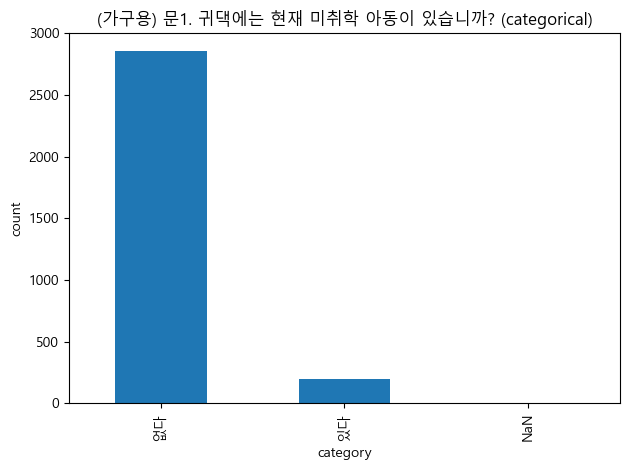

In [29]:
# Set Korean font for Windows
plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'NanumGothic' if installed
plt.rcParams['axes.unicode_minus'] = False

summaries = []
for col in data_labeled.columns:
    s = data_labeled[col]
    vtype = infer_var_type(s)
    entry = {"column": col, "type": vtype}
    if vtype == 'numeric':
        stats = summarize_numeric(s)
        entry.update(stats)
        plot_numeric_hist(s, f"{col} (numeric)", OUTDIR / "charts" / f"{col}_hist.png")
        pd.DataFrame([entry]).to_csv(OUTDIR / "tables" / f"{col}_summary.csv", index=False, encoding="utf-8-sig")
    elif vtype == 'categorical':
        freq = summarize_categorical(s)
        plot_categorical_bar(s, f"{col} (categorical)", OUTDIR / "charts" / f"{col}_bar.png")
        freq.to_csv(OUTDIR / "tables" / f"{col}_freq.csv", index=False, encoding="utf-8-sig")
        entry["n_categories"] = int(freq.shape[0])
    else:
        entry["note"] = "text-like; skipped"
    summaries.append(entry)

summary_df = pd.DataFrame(summaries)
summary_df.to_csv(OUTDIR / "variables_overview.csv", index=False, encoding="utf-8-sig")
summary_df.head(10)

In [30]:

# 미리보기: 라벨 적용/미적용 요약
print(json.dumps(label_report, ensure_ascii=False)[:1000], "...")

# 임의의 범주형/수치형 하나씩 골라 미리보기
cat_cols = [c for c,t in zip(summary_df['column'], summary_df['type']) if t=='categorical']
num_cols = [c for c,t in zip(summary_df['column'], summary_df['type']) if t=='numeric']

if cat_cols:
    c = cat_cols[0]
    display(pd.read_csv(OUTDIR / "tables" / f"{c}_freq.csv").head(10))
if num_cols:
    c = num_cols[0]
    display(pd.read_csv(OUTDIR / "tables" / f"{c}_summary.csv"))

print("출력 디렉토리:", OUTDIR)

{"labeled_cols": ["(가구용) 문0. 가구 정보 - 1. 거주 주택 유형", "(가구용) 문0. 가구 정보 - 2. 1인 가구 여부", "(가구용) 문0. 가구 정보 - 3. 맞벌이 여부(가구주 기준)", "(가구용) 문0. 가구원1 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원1 성별", "(가구용) 문0. 가구원1 혼인상태", "(가구용) 문0. 가구원1 학력", "(가구용) 문0. 가구원1 등록 장애 여부", "(가구용) 문0. 가구원2 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원2 성별", "(가구용) 문0. 가구원2 혼인상태", "(가구용) 문0. 가구원2 학력", "(가구용) 문0. 가구원2 등록 장애 여부", "(가구용) 문0. 가구원3 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원3 성별", "(가구용) 문0. 가구원3 혼인상태", "(가구용) 문0. 가구원3 학력", "(가구용) 문0. 가구원3 등록 장애 여부", "(가구용) 문0. 가구원4 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원4 성별", "(가구용) 문0. 가구원4 혼인상태", "(가구용) 문0. 가구원4 학력", "(가구용) 문0. 가구원4 등록 장애 여부", "(가구용) 문0. 가구원5 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원5 성별", "(가구용) 문0. 가구원5 혼인상태", "(가구용) 문0. 가구원5 학력", "(가구용) 문0. 가구원5 등록 장애 여부", "(가구용) 문0. 가구원6 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원6 성별", "(가구용) 문0. 가구원6 혼인상태", "(가구용) 문0. 가구원6 학력", "(가구용) 문0. 가구원6 등록 장애 여부", "(가구용) 문0. 가구원7 가구대표자(응답자)와의 관계", "(가구용) 문0. 가구원7 성별", "(가구용) 문0. 가구원7 혼인상태", "(가구용) 문0. 가구원7 학력", "(가구용) 문0. 가구원7 등록 장애 

NameError: name 'summary_df' is not defined